In [1]:
%matplotlib inline
from __future__ import division, print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
!ls

compute_imp_scores.py
compute_imp_scores.pyc
config
dan_basset_keras_port
dinucshuff_motifs_inserted_sigthresh5e-6_sorted_naive_window_around_summit.bed.gz
insert_motifs_in_dincuc_shuff_regions.py
model_files
motif_hits_sorted_naive_window_around_summit.bed.gz
nonoverlap_dinucshuff_motifs_inserted_sigthresh5e-6_merged_universal_neg_representative_peaks.bed.gz
runs_perf-metric-auROC.db
sorted_naive_window_around_summit.bed.gz
sorted_naive_window_around_summit.fa.gz
Study Simulated Importance.ipynb
test_set_negatives.bed.gz
test_set_positives.bed.gz
train_dinucshuff_motifs_inserted_sigthresh5e-6_sorted_naive_window_around_summit.bed.gz
train_nonoverlap_dinucshuff_motifs_inserted_sigthresh5e-6_merged_universal_neg_representative_peaks.bed.gz
train_sim_model_from_preinit.sh
valid_labels.gz


In [3]:
!zcat test_set_positives.bed.gz | wc -l

18421


In [4]:
import gzip
from collections import namedtuple

MotifHit = namedtuple("MotifHit",['offset', 'motif_id',
                                  'motif_factor', 'motif_seq',
                                  'motif_strand', 'motif_sig'])
def parse_motif_hit(string):
    (offset,motif_id,motif_factor,
     motif_seq,motif_strand,motif_sig) = string.split(",")
    
    offset = int(offset)
    motif_sig = float(motif_sig)
    return MotifHit(offset=offset,
                    motif_id=motif_id,
                    motif_factor=motif_factor,
                    motif_seq=motif_seq,
                    motif_strand=motif_strand,
                    motif_sig=motif_sig)

def parse_sim_file(file_name):
    seqs = []
    motifs_arr = []
    seq_ids = []
    
    for line in gzip.open(file_name):
        line = line.rstrip("\n")
        chrom,start,end,seq_id,seq,motifs = line.split("\t")
        seqs.append(seq)
        motifs_arr.append([parse_motif_hit(x) for x in motifs.split(";")] if len(motifs) > 0 else [])
        seq_ids.append(seq_id)
    return seqs, motifs_arr, seq_ids

original_positives_seqs, original_positives_motifs, original_positives_ids = parse_sim_file("test_set_positives.bed.gz")
negatives_seqs, negatives_motifs, negatives_ids = parse_sim_file("test_set_negatives.bed.gz")

In [5]:
positives_seqs = original_positives_seqs[::10]
positives_motifs = original_positives_motifs[::10]
positives_ids = original_positives_ids[::10]

In [6]:
from collections import Counter
positives_motif_counts_in_central_300 = Counter([x.motif_factor+":"+x.motif_id for y in positives_motifs for x in y
                                       if (x.offset > 350 and (x.offset + len(x.motif_seq))<650)])
negatives_motif_counts_in_central_300 = Counter([x.motif_factor+":"+x.motif_id for y in negatives_motifs for x in y
                                       if (x.offset > 350 and (x.offset + len(x.motif_seq))<650)])


In [7]:
ratios = dict([(x,((positives_motif_counts_in_central_300[x])
                   *(len(negatives_seqs)/len(positives_seqs))/(negatives_motif_counts_in_central_300[x]),
                   positives_motif_counts_in_central_300[x]))
                for x in negatives_motif_counts_in_central_300.keys()
                if positives_motif_counts_in_central_300[x] > 20])
sorted(ratios.items(), key=lambda x: -x[1][0])

[('DNMT1:M0609_1.02', (51.66150257934419, 166)),
 ('(ZFP161)_(Mus_musculus)_(DBD_1.00):M0432_1.02', (36.853512347158954, 38)),
 ('NRF1:M2305_1.02', (34.2400776765571, 78)),
 ('E2F1:M4536_1.02', (28.400038462330954, 269)),
 ('SP4:M6483_1.02', (27.756639724898, 2050)),
 ('MBD2:M6337_1.02', (23.96704523484324, 50)),
 ('EGR1:M4459_1.02', (14.471131064997751, 516)),
 ('(SP5)_(Drosophila_melanogaster)_(DBD_0.93):M5209_1.02',
  (14.012093326098753, 168)),
 ('ZBTB7B:M6539_1.02', (13.158819899075299, 1194)),
 ('(TCFL5)_(Mus_musculus)_(DBD_1.00):M0212_1.02', (13.054745334874616, 36)),
 ('CTCFL:M4612_1.02', (13.017465428674297, 167)),
 ('(KLF12)_(Mus_musculus)_(DBD_1.00):M0443_1.02', (12.576992308951072, 152)),
 ('SP3:M6482_1.02', (11.719741173620719, 1123)),
 ('ZBTB7A:M4640_1.02', (11.620403090099991, 231)),
 ('(KLF7)_(Mus_musculus)_(DBD_1.00):M0405_1.02', (11.261170905639759, 155)),
 ('ZFX:M6547_1.02', (11.178780576377015, 308)),
 ('WT1:M6535_1.02', (10.221905758385017, 301)),
 ('KLF14:M5592_1.

In [8]:
from deeplift import dinuc_shuffle
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

onehot_positives = np.array([one_hot_encode_along_channel_axis(x)
                             for x in positives_seqs])

In [9]:
!ls model_files/

model_iNu96_modelJson.json   record_1_model_Ba1Th_modelJson.json
model_iNu96_modelWeights.h5  record_1_model_Ba1Th_modelWeights.h5
model_mVLUO_modelJson.json   record_2_model_fijFp_modelJson.json
model_mVLUO_modelWeights.h5  record_2_model_fijFp_modelWeights.h5


In [10]:
def get_scoring_functions(model_json, model_weights):
    
    deeplift_genomicsdefault_model =\
    kc.convert_model_from_saved_files(
        json_file=model_json,
        h5_file=model_weights,
        nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.DeepLIFT_GenomicsDefault) 
    
    deeplift_rescale_model =\
        kc.convert_model_from_saved_files(
            json_file=model_json,
            h5_file=model_weights,
            nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.Rescale) 

In [11]:
import deeplift
from keras import backend as K
from deeplift.conversion import kerasapi_conversion as kc
from compute_imp_scores import get_scoring_funcs

model_id = "record_1_model_Ba1Th"
model_json = "model_files/"+model_id+"_modelJson.json"
model_weights = "model_files/"+model_id+"_modelWeights.h5"

pred_func, method_name_to_scoring_func = get_scoring_funcs(model_json, model_weights)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 2 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 6 the preceding linear layer is 4 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 10 the preceding linear layer is 8 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 15 the preceding linear layer is 13 of type Dense;
In accordance with nonlinea

Using TensorFlow backend.


In [12]:
positives_preds = np.array(deeplift.util.run_function_in_batches(
                            func=pred_func,
                            input_data_list=[onehot_positives]))

Done 0
Done 1000


In [13]:
positives_preds.shape

(1843,)

(array([  1.,   0.,  66., 253., 193., 193., 225., 372., 456.,  84.]),
 array([-31.56965065, -25.53940239, -19.50915413, -13.47890587,
         -7.44865761,  -1.41840935,   4.61183891,  10.64208717,
         16.67233543,  22.70258369,  28.73283195]),
 <a list of 10 Patch objects>)

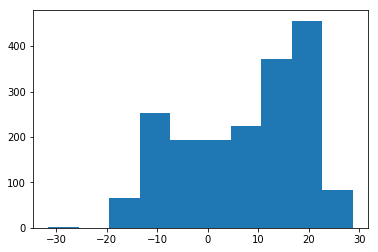

In [14]:
from matplotlib import pyplot as plt
plt.hist(positives_preds)

In [16]:
import time

method_name_to_scores = {}

for method_name in [
                    'grad_times_inp',                                   
                    #'integrated_grad2',                                 
                    #'integrated_grad5',                                 
                    #'integrated_grad10',                                
                    #'integrated_grad20',                                
                    'deeplift_rescale',                                 
                    'deeplift_genomicsdefault'
                   ]:                                                   
    print(method_name)                                                  
    print("flatref")                                                    
    scoring_func = method_name_to_scoring_func[method_name]             
    start = time.time()                                                 
    scores_flatref = np.array(                                          
     scoring_func(input_data_list=[onehot_positives],                 
     input_references_list=[np.zeros_like(onehot_positives)],         
     task_idx=0, batch_size=10, progress_update=1000))                  
    print("Time taken for",method_name,"flatref",time.time()-start)  
    method_name_to_scores[method_name+"_flatref"] = scores_flatref
    
    print("avgposref")                                                  
    start = time.time() 
    avgpos_gcref = np.mean(onehot_positives,axis=0)
    scores_avgposref = np.array(
        scoring_func(                                                   
         input_data_list=[onehot_positives],                          
         input_references_list=[                                        
          np.array([avgpos_gcref for x in onehot_positives])],     
         task_idx=0, batch_size=10, progress_update=1000))              
    print("Time taken for",method_name,"avgposref",time.time()-start)   
    method_name_to_scores[method_name+"_avgposref"] = scores_avgposref                                      

for method_name in [
                    'deeplift_rescale_dinucshuff',                      
                    'deeplift_genomicsdefault_dinucshuff',              
                    'integrated_grad2_dinucshuff',                      
                    #'integrated_grad5_dinucshuff',                      
                    #'integrated_grad10_dinucshuff',                     
                    #'integrated_grad20_dinucshuff'
                   ]:                    
    print(method_name)                                                  
    start = time.time()                                                 
    scores_shuffref = method_name_to_scoring_func[method_name](         
        task_idx=0,                                                     
        input_data_sequences=positives_seqs,
        num_refs_per_seq=10,                                            
        batch_size=10, seed=1,                                         
        progress_update=1000)                                         
    print("Time taken for",method_name,time.time()-start)               
    method_name_to_scores[method_name] = scores_shuffref                   

#for method_name in ['ism']:                                             
#    print(method_name)                                                  
#    start = time.time()                                                 
#    scoring_func = method_name_to_scoring_func[method_name]             
#    scores_ism = np.array(                                              
#     scoring_func(input_data_list=[onehot_positives],                 
#                  progress_update=10000))                               
#    print("Time taken for",method_name,time.time()-start)             
#    file_to_save_in.create_dataset(                                     
#     "scores_"+method_name,data=np.sum(scores_ism,axis=-1))            
#    method_to_ism_score[method_name] = scores_ism

deeplift_rescale_dinucshuff
1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
9000 reference seqs generated
10000 reference seqs generated
11000 reference seqs generated
12000 reference seqs generated
13000 reference seqs generated
14000 reference seqs generated
15000 reference seqs generated
16000 reference seqs generated
17000 reference seqs generated
18000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 10000
Done 11000
Done 12000
Done 13000
Done 14000
Done 15000
Done 16000
Done 17000
Done 18000
Time taken for deeplift_rescale_dinucshuff 142.907013893
deeplift_genomicsdefault_dinucshuff
1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs

In [17]:
sorted_prediction_indices = sorted(enumerate(positives_preds), key=lambda x: -x[1])

47
28.732832
(56, MotifHit(offset=406, motif_id='M0413_1.02', motif_factor='(ZBTB1)_(Mus_musculus)_(DBD_0.99)', motif_seq='GCCCCGCATC', motif_strand='-', motif_sig=3.65e-06))
(75, MotifHit(offset=425, motif_id='M6259_1.02', motif_factor='GCM1', motif_seq='CGTCCCCGCATGAG', motif_strand='-', motif_sig=4.25e-06))
(127, MotifHit(offset=477, motif_id='M6516_1.02', motif_factor='TCF3', motif_seq='GCCAGATGCTC', motif_strand='-', motif_sig=4.21e-06))
(127, MotifHit(offset=477, motif_id='M6554_1.02', motif_factor='ZNF238', motif_seq='GCCAGATGCTCCGA', motif_strand='+', motif_sig=3.36e-06))
(275, MotifHit(offset=625, motif_id='M6392_1.02', motif_factor='NR2F6', motif_seq='GCCTGTGGCCCTTGACCC', motif_strand='+', motif_sig=1.61e-06))
(279, MotifHit(offset=629, motif_id='M6433_1.02', motif_factor='PPARG', motif_seq='GTGGCCCTTGACCCTGTC', motif_strand='+', motif_sig=3.55e-06))
(280, MotifHit(offset=630, motif_id='M2286_1.02', motif_factor='HNF4G', motif_seq='TGGCCCTTGACCCTG', motif_strand='+', motif_si

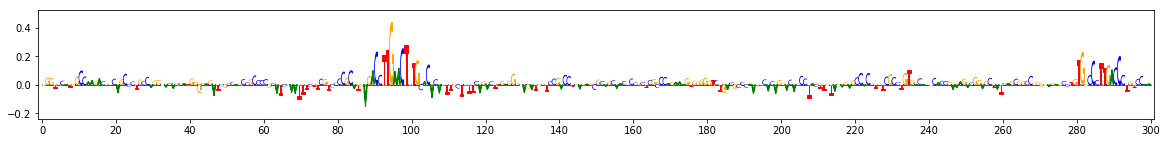

method deeplift_genomicsdefault_dinucshuff


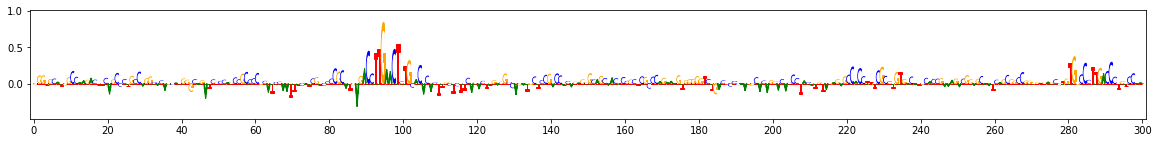

method integrated_grad2_dinucshuff


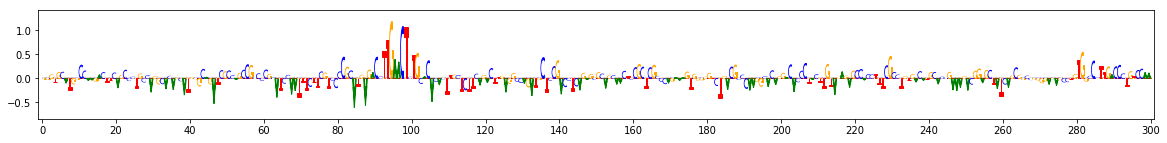

11
28.512302
(56, MotifHit(offset=406, motif_id='M2289_1.02', motif_factor='JUN', motif_seq='ATGACATCATCAT', motif_strand='-', motif_sig=6.46e-08))
(68, MotifHit(offset=418, motif_id='M2065_1.02', motif_factor='ESR2', motif_seq='TGGACATTGTGACCC', motif_strand='+', motif_sig=3.4e-06))
(68, MotifHit(offset=418, motif_id='M4438_1.02', motif_factor='ESRRA', motif_seq='TGGACATTGTGACCC', motif_strand='+', motif_sig=4.54e-06))
(76, MotifHit(offset=426, motif_id='M6433_1.02', motif_factor='PPARG', motif_seq='GTGACCCCTGCCCTCCAG', motif_strand='+', motif_sig=9.87e-07))
(77, MotifHit(offset=427, motif_id='M6176_1.02', motif_factor='NR2F1', motif_seq='TGACCCCTGCCC', motif_strand='+', motif_sig=1.69e-06))
(77, MotifHit(offset=427, motif_id='M2303_1.02', motif_factor='NR2C2', motif_seq='TGACCCCTGCCCTCC', motif_strand='+', motif_sig=2.55e-07))
(132, MotifHit(offset=482, motif_id='M6482_1.02', motif_factor='SP3', motif_seq='TCACAGCCCGGCCCCTGCCC', motif_strand='-', motif_sig=3.01e-06))
(135, MotifHit(o

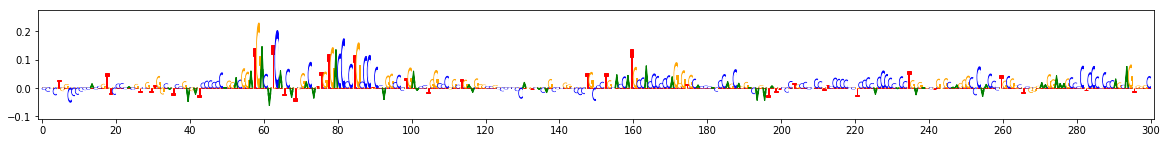

method deeplift_genomicsdefault_dinucshuff


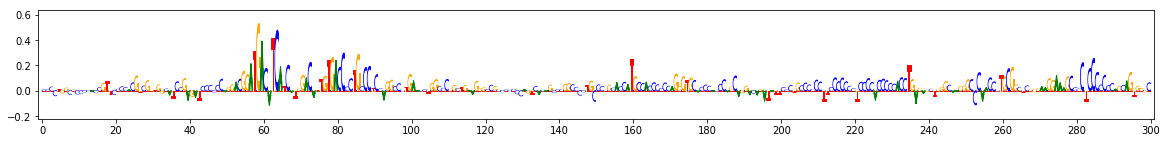

method integrated_grad2_dinucshuff


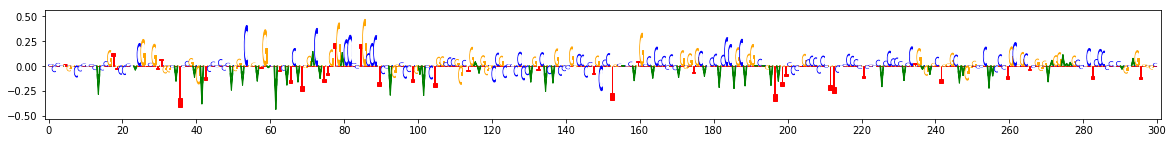

1491
28.329937
(38, MotifHit(offset=388, motif_id='M6547_1.02', motif_factor='ZFX', motif_seq='GGCGGCTCAAGGCCCAGGC', motif_strand='+', motif_sig=1.03e-06))
(58, MotifHit(offset=408, motif_id='M6281_1.02', motif_factor='HNF1A', motif_seq='GGGAAATGATTAACC', motif_strand='+', motif_sig=2.34e-07))
(107, MotifHit(offset=457, motif_id='M6552_1.02', motif_factor='ZNF148', motif_seq='CCCCTCACCCCCTGC', motif_strand='-', motif_sig=1.66e-06))
(112, MotifHit(offset=462, motif_id='M6326_1.02', motif_factor='KLF8', motif_seq='CACCCCCTG', motif_strand='-', motif_sig=2.23e-06))
(119, MotifHit(offset=469, motif_id='M6463_1.02', motif_factor='SMAD1', motif_seq='TGCAGACAGGCC', motif_strand='-', motif_sig=4.82e-07))
(125, MotifHit(offset=475, motif_id='M1963_1.02', motif_factor='(ZFY)_(Mus_musculus)_(DBD_0.97)', motif_seq='CAGGCCTGGCCCAG', motif_strand='-', motif_sig=1.28e-06))
(141, MotifHit(offset=491, motif_id='M4476_1.02', motif_factor='RFX5', motif_seq='TCACTGGTCACCAGG', motif_strand='+', motif_sig=4

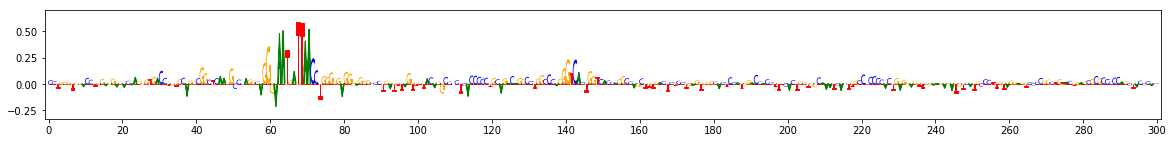

method deeplift_genomicsdefault_dinucshuff


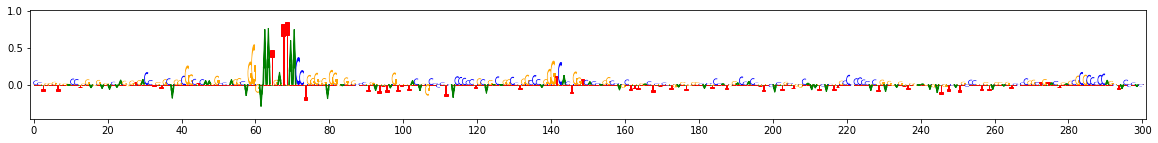

method integrated_grad2_dinucshuff


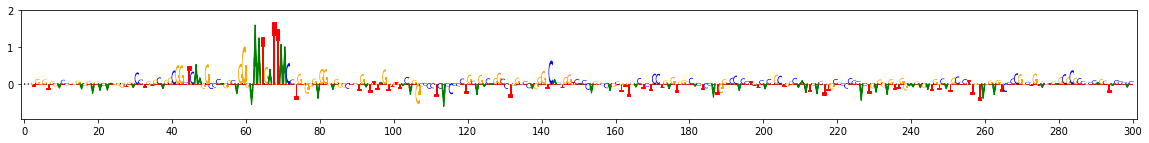

117
27.245289
(7, MotifHit(offset=357, motif_id='M6270_1.02', motif_factor='NHLH1', motif_seq='GTGGGCGCAGCAGCGGGGCC', motif_strand='-', motif_sig=1.07e-06))
(18, MotifHit(offset=368, motif_id='M6547_1.02', motif_factor='ZFX', motif_seq='AGCGGGGCCTGGGGCAGGG', motif_strand='-', motif_sig=2.55e-07))
(19, MotifHit(offset=369, motif_id='M4525_1.02', motif_factor='TFAP2C', motif_seq='GCGGGGCCTGGGGCA', motif_strand='-', motif_sig=4.65e-06))
(22, MotifHit(offset=372, motif_id='M1838_1.02', motif_factor='TFAP2A', motif_seq='GGGCCTGGGGCAGGG', motif_strand='-', motif_sig=2.16e-06))
(23, MotifHit(offset=373, motif_id='M6482_1.02', motif_factor='SP3', motif_seq='GGCCTGGGGCAGGGCCAGAG', motif_strand='+', motif_sig=2.45e-06))
(227, MotifHit(offset=577, motif_id='M4525_1.02', motif_factor='TFAP2C', motif_seq='TCAAGGCCTCAGGCC', motif_strand='-', motif_sig=4.85e-06))
(228, MotifHit(offset=578, motif_id='M1838_1.02', motif_factor='TFAP2A', motif_seq='CAAGGCCTCAGGCCA', motif_strand='+', motif_sig=6.53e-07)

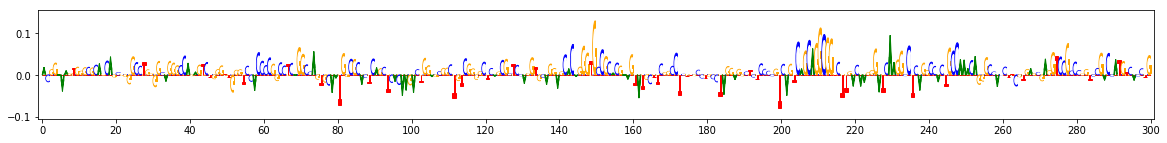

method deeplift_genomicsdefault_dinucshuff


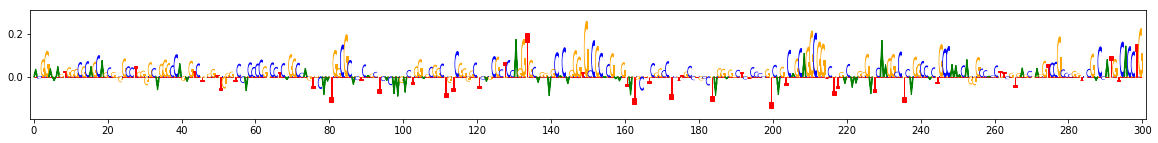

method integrated_grad2_dinucshuff


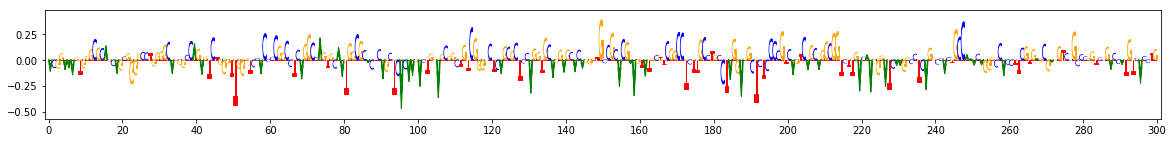

267
26.686575
(88, MotifHit(offset=438, motif_id='M6420_1.02', motif_factor='PLAG1', motif_seq='GGAGGCAGGAGGAGAGG', motif_strand='+', motif_sig=1.85e-06))
(90, MotifHit(offset=440, motif_id='M4604_1.02', motif_factor='ZNF263', motif_seq='AGGCAGGAGGAGAGGGAGGCC', motif_strand='+', motif_sig=2.53e-06))
(93, MotifHit(offset=443, motif_id='M6336_1.02', motif_factor='MAZ', motif_seq='CAGGAGGAGAGGGAGGC', motif_strand='+', motif_sig=2.18e-06))
(169, MotifHit(offset=519, motif_id='M5209_1.02', motif_factor='(SP5)_(Drosophila_melanogaster)_(DBD_0.93)', motif_seq='CTGGGCGGGGC', motif_strand='+', motif_sig=3.11e-06))
(170, MotifHit(offset=520, motif_id='M0405_1.02', motif_factor='(KLF7)_(Mus_musculus)_(DBD_1.00)', motif_seq='TGGGCGGGGC', motif_strand='+', motif_sig=1.83e-06))
(170, MotifHit(offset=520, motif_id='M0443_1.02', motif_factor='(KLF12)_(Mus_musculus)_(DBD_1.00)', motif_seq='TGGGCGGGGC', motif_strand='+', motif_sig=9.16e-07))
(170, MotifHit(offset=520, motif_id='M1871_1.02', motif_factor

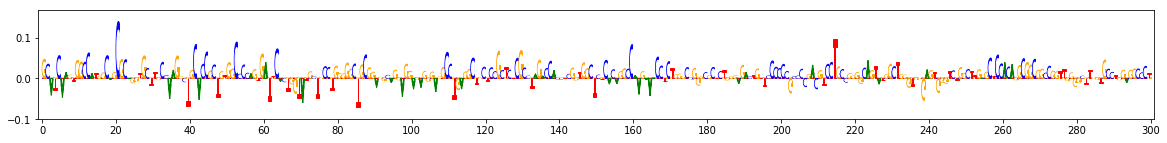

method deeplift_genomicsdefault_dinucshuff


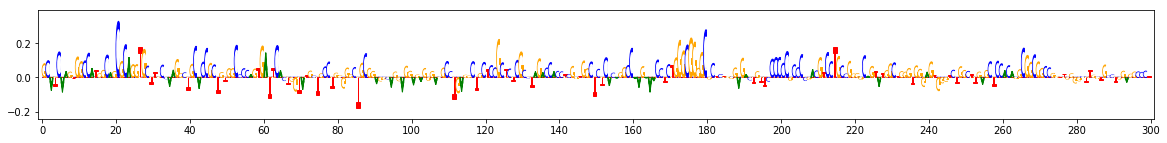

method integrated_grad2_dinucshuff


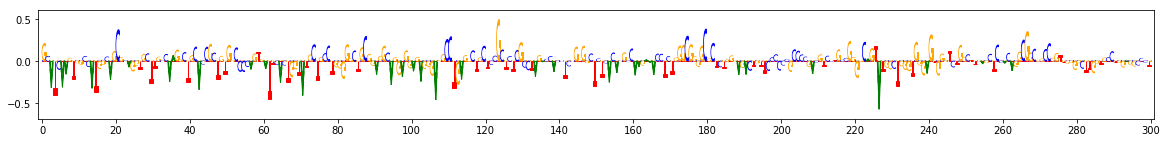

In [30]:
from deeplift.visualization import viz_sequence

method_names = ['deeplift_rescale_dinucshuff',                      
                'deeplift_genomicsdefault_dinucshuff',              
                'integrated_grad2_dinucshuff',
                #'grad_times_inp_avgposref',                                   
                #'deeplift_rescale_avgposref',                                 
                #'deeplift_genomicsdefault_avgposref'
               ]
for rank in range(5):
    idx = sorted_prediction_indices[rank][0]
    print(idx)
    print(positives_preds[idx])
    print("\n".join([str((x.offset-350,x)) for x in positives_motifs[idx] if x.offset > 350 and (x.offset + len(x.motif_seq)) < 650]))
    for method_name in method_names:
        print("method",method_name)
        viz_sequence.plot_weights((method_name_to_scores[method_name][idx]*onehot_positives[idx])[350:650],
                                  subticks_frequency=20)

In [25]:
method_name_to_scores.keys()

['deeplift_rescale_dinucshuff',
 'deeplift_genomicsdefault_dinucshuff',
 'integrated_grad2_dinucshuff']